# Multi-sample Pipeline: analyzing snATAC-seq data of human colon samples

## Introduction

In this tutorial, we will perform integrative analysis of snATAC-seq data of colon sample from multiple donors. 

In [1]:
import snapatac2 as snap
import numpy as np

snap.__version__

'2.3.2dev1'

Download the example dataset.

In [2]:
files = snap.datasets.colon()
files

[('colon_transverse_SM-A9VP4',
  PosixPath('/home/kaizhang/.cache/snapatac2/colon_transverse.tar.untar/colon_transverse_SM-A9VP4_rep1_fragments.bed.gz')),
 ('colon_transverse_SM-BZ2ZS',
  PosixPath('/home/kaizhang/.cache/snapatac2/colon_transverse.tar.untar/colon_transverse_SM-BZ2ZS_rep1_fragments.bed.gz')),
 ('colon_transverse_SM-A9HOW',
  PosixPath('/home/kaizhang/.cache/snapatac2/colon_transverse.tar.untar/colon_transverse_SM-A9HOW_rep1_fragments.bed.gz')),
 ('colon_transverse_SM-CSSDA',
  PosixPath('/home/kaizhang/.cache/snapatac2/colon_transverse.tar.untar/colon_transverse_SM-CSSDA_rep1_fragments.bed.gz')),
 ('colon_transverse_SM-ACCQ1',
  PosixPath('/home/kaizhang/.cache/snapatac2/colon_transverse.tar.untar/colon_transverse_SM-ACCQ1_rep1_fragments.bed.gz'))]

First we use `pp.import_data` to import the fragment files. Here we use the thresholds used in our previous paper to filter the cells.

In [3]:
%%time
adatas = snap.pp.import_data(
    [fl for _, fl in files],
    file=[name + '.h5ad' for name, _ in files],
    genome=snap.genome.hg38,
    min_tsse=7,
    min_num_fragments=1000,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.74s/it]


CPU times: user 203 ms, sys: 214 ms, total: 417 ms
Wall time: 54.5 s


We then follow the standard procedures to add tile matrices, select features, and identify doublets. Note these functions can take either a single AnnData object or a list of AnnData objects.

In [4]:
%%time
snap.pp.add_tile_matrix(adatas, bin_size=5000)
snap.pp.select_features(adatas, n_features=50000)
snap.pp.scrublet(adatas)
snap.pp.filter_doublets(adatas)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.16s/it]


CPU times: user 375 ms, sys: 843 ms, total: 1.22 s
Wall time: 2min 33s


## Creating AnnDataSet object

We then create an `AnnDataSet` object which contains links to individual data. The data are not loaded into memory so it can scale to very large dataset.

In [5]:
%%time
data = snap.AnnDataSet(
    adatas=[(name, adata) for (name, _), adata in zip(files, adatas)],
    filename="colon.h5ads"
)
data

CPU times: user 412 ms, sys: 59.6 ms, total: 471 ms
Wall time: 554 ms


AnnDataSet object with n_obs x n_vars = 39589 x 606219 backed at 'colon.h5ads'
contains 5 AnnData objects with keys: 'colon_transverse_SM-A9VP4', 'colon_transverse_SM-BZ2ZS', 'colon_transverse_SM-A9HOW', 'colon_transverse_SM-CSSDA', 'colon_transverse_SM-ACCQ1'
    obs: 'sample'
    uns: 'reference_sequences', 'AnnDataSet'

When merging multiple h5ad files, SnapATAC2 automatically adds a column to `.obs['sample']`, indicating the origin of the cells. After merging, `.obs_names` are no longer garanteed to be unique, as some barcodes may be shared across experiments. So it is advised to regenerate unique IDs by concatenating `.obs_names` and sample IDs.

In [6]:
data.obs_names = np.array(data.obs['sample']) + ":" + np.array(data.obs_names)

In [7]:
snap.pp.select_features(data, n_features=50000)

2023-09-09 21:35:01 - INFO - Selected 50000 features.


In [8]:
%%time
snap.tl.spectral(data)

CPU times: user 3min 7s, sys: 8.12 s, total: 3min 15s
Wall time: 30.9 s


We next perform UMAP embedding and visualize the result.

In [9]:
%%time
snap.tl.umap(data)

CPU times: user 2min 27s, sys: 2.36 s, total: 2min 30s
Wall time: 2min 14s


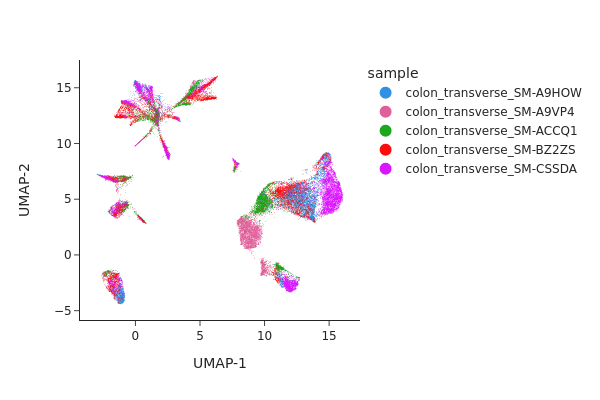

In [10]:
snap.pl.umap(data, color="sample", interactive=False)

## Batch correction

From the UMAP plot above we can clearly see some donor/individual specific effects. Although these donor differences are interesting to study on their own, it obscures the clustering procedure for identifying shared cell states across individuals.

Here we apply two different approaches, Harmony and modified MNNCorrect, to remove donor specific differences.

In [11]:
%%time
snap.pp.mnc_correct(data, batch="sample")
snap.pp.harmony(data, batch="sample", max_iter_harmony=20)

2023-09-09 21:38:12,164 - harmonypy - INFO - Iteration 1 of 20
2023-09-09 21:38:12 - INFO - Iteration 1 of 20
2023-09-09 21:38:21,272 - harmonypy - INFO - Iteration 2 of 20
2023-09-09 21:38:21 - INFO - Iteration 2 of 20
2023-09-09 21:38:29,336 - harmonypy - INFO - Iteration 3 of 20
2023-09-09 21:38:29 - INFO - Iteration 3 of 20
2023-09-09 21:38:31,853 - harmonypy - INFO - Converged after 3 iterations
2023-09-09 21:38:31 - INFO - Converged after 3 iterations


CPU times: user 3min 28s, sys: 8.4 s, total: 3min 37s
Wall time: 40.2 s


Visualizing the result of MNNCorrect.

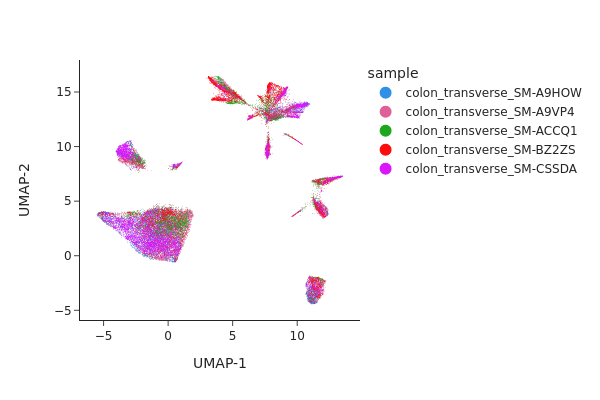

In [12]:
snap.tl.umap(data, use_rep="X_spectral_mnn")
snap.pl.umap(data, color="sample", interactive=False)

Visualize the result of Harmony.

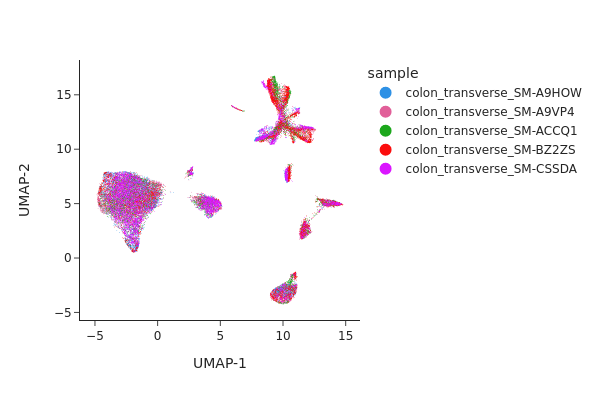

In [13]:
snap.tl.umap(data, use_rep="X_spectral_harmony")
snap.pl.umap(data, color="sample", interactive=False)

Both methods have effectively eliminated the unwanted effects, as can be seen. While we do not offer a recommendation for one method over the other, it's worth noting that Harmony's algorithm sometimes may significantly alter the underlying topology and generate artificial clusters.

## Clustering

In [14]:
snap.pp.knn(data, use_rep="X_spectral_harmony")

In [15]:
snap.tl.leiden(data)

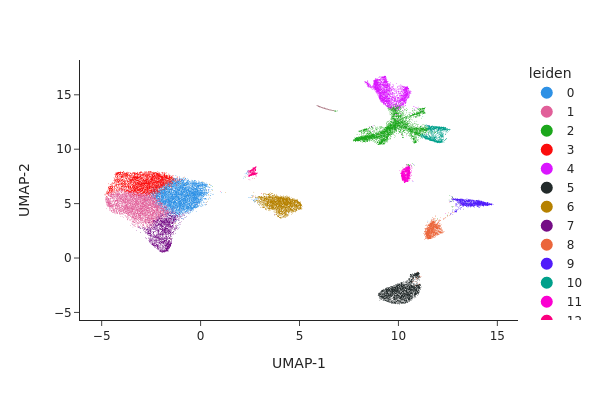

In [16]:
snap.pl.umap(data, color="leiden", interactive=False)

## AnnDataSet object IO

Just like the AnnData object, AnnDataSet object is synchronized with the content of the HDF5 file. Therefore, there is no need to manually save the result. After the analysis is finished, simply close the file by:

In [17]:
data.close()
data

Closed AnnDataSet object

The AnnDataSet object is stored as a standard h5ad file, in which the links to individual anndata file was saved in `uns['AnnDataSet']` and can be reopened by `snap.read_dataset`.

In [18]:
data = snap.read_dataset("colon.h5ads")
data

AnnDataSet object with n_obs x n_vars = 39589 x 606219 backed at 'colon.h5ads'
contains 5 AnnData objects with keys: 'colon_transverse_SM-A9VP4', 'colon_transverse_SM-BZ2ZS', 'colon_transverse_SM-A9HOW', 'colon_transverse_SM-CSSDA', 'colon_transverse_SM-ACCQ1'
    obs: 'sample', 'leiden'
    var: 'count', 'selected'
    uns: 'AnnDataSet', 'reference_sequences', 'spectral_eigenvalue'
    obsm: 'X_spectral_mnn', 'X_spectral_harmony', 'X_umap', 'X_spectral'
    obsp: 'distances'

Because the AnnDataSet object does not copy the underlying AnnData objects, if you move the component h5ad files then it won't be able to find them. In this case, you can supply the new locations using the `update_data_locations` parameter:

In [19]:
data.close()

In [20]:
data = snap.read_dataset(
    "colon.h5ads",
    update_data_locations = {"colon_transverse_SM-CSSDA": "colon_transverse_SM-CSSDA.h5ad"},
)
data

AnnDataSet object with n_obs x n_vars = 39589 x 606219 backed at 'colon.h5ads'
contains 5 AnnData objects with keys: 'colon_transverse_SM-A9VP4', 'colon_transverse_SM-BZ2ZS', 'colon_transverse_SM-A9HOW', 'colon_transverse_SM-CSSDA', 'colon_transverse_SM-ACCQ1'
    obs: 'sample', 'leiden'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue', 'reference_sequences', 'AnnDataSet'
    obsm: 'X_umap', 'X_spectral', 'X_spectral_mnn', 'X_spectral_harmony'
    obsp: 'distances'

In [21]:
data.close()